# チュートリアル2: MLPの使い方を理解しよう

## このノードブックの目的
- pytorch で構築したサンプル用MLP モデルを使って、実際に推論を試し、サンプル用モデルの入出力形式を理解する。

### チュートリアル 1と同じくブロックを可視化する関数とサンプル用テストデータを定義しましょう.

## 0.1. matplotlibのインストール 
可視化用のライブラリ[matplotlib](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html)をインストールします。

In [5]:
!pip install matplotlib

You should consider upgrading via the '/Users/ishibushisatoshi/tetris/.venv/bin/python3.7 -m pip install --upgrade pip' command.


In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

## 0.2. サンプル用テストデータの準備
- AIモデルに入力するサンプル用テストデータをロードします。
- チュートリアルとして10パターンのテストデータを格納した .npz ファイルを用意しています。

In [8]:
import numpy as np
tutorial_data = np.load("./test_data10.npz") #1~10までのサンプル用状態データをロード

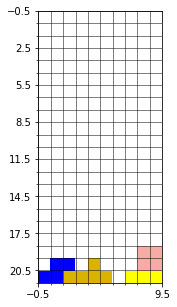

In [9]:
colors = [[255,255,255],
          [255,0,0],
          [0,255,0],
          [255,255,0], 
          [218, 179, 0],
          [247, 171, 166],
          [0,0,255],
          [255,255,0]]

#ブロック可視化関数 (numpy 配列からテトリスの盤面を可視化)
def visualize_block(data, shape, size=0.5):
    block_array = []
    fig, ax = plt.subplots()
    fig.set_figwidth(shape[0] * size)
    fig.set_figheight(shape[1] * size)
    for i in range(shape[0]):
        row = []
        for j in range(shape[1]):
            c = colors[int(data[i][j])]
            row.append(c)
        block_array.append(row)
    block_array = np.array(block_array)
    im = plt.imshow(block_array)

    #グリッド線を引く
    ax.set_xticks(np.arange(-0.5, 10, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, 23, 1.0), minor=True)
    ax.set_xticks(np.arange(-0.5, 10,10))
    ax.set_yticks(np.arange(-0.5, 23, 3))
    ax.grid(which='minor', color='black', linestyle='-', linewidth=0.5)
    ax.grid(which='major', color='black', linestyle='-', linewidth=0.5)
    ax.imshow(block_array)
    
shape = tutorial_data["1"].shape 
visualize_block(tutorial_data["1"],shape) #サンプル用状態データ１を可視化


# 2章 AIモデル(MLP)に状態の価値を推論させよう！
- 次にサンプル用テストデータを用いて、AIモデル(MLP)に推論をさせてみましょう。
- DQN では状態を　22x10　のテンソルとして表現します。

In [13]:
import sys
sys.path.append("../")
sys.path.append("../../../")
from deepqnet import MLP
import torch

## 2.1 MLPモデルをロード
- MLPモデルをロードしましょう。　
- ロード方法は1.1 と同様です。
- 今回はサンプル用の重みファイル　"tetris/weight/MLP/sample_weight.pt" を使ってみてください。

In [15]:
model = torch.load("../../../../weight/MLP/sample_weight.pt") 

## 2.2テストデータのロード
- 実際にモデルを使って状態（テトリスの盤面）の価値を推定するためのテストデータをロードしましょう。
- 0.2. で準備したサンプルデータを使って、モデルの入出力がどのような形式かを確認してみてください。

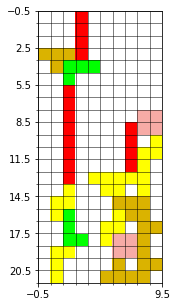

In [26]:
# ###index を1~10の番号に変えてみてください###

data_index =  8

# #######################################

tutorial_data = np.load("./test_data10.npz") #1~10までのサンプル用状態データをロード
load_data = tutorial_data[repr(data_index)] 
shape = load_data.shape
visualize_block(load_data ,shape) #データを可視化

- サンプル用MLPモデルではshape=(batch_size,4)のテンソルを入力とします。
- また、状態のテンソルの各要素は0以上の整数になり、それぞれ（削除する行数, ブロック間の穴の数, 列毎の高さ差分, 高さの合計) を示す。
- 盤面を４次元のテンソルに変換するには下記の手順で実行する。
    1. get_reshape_backboard()を用いて状態のデータを1,0の２値データ化
    2. get_state_properties()を用いて1.の出力を４次元のテンソルに変換
    
- get_state_propertiesは３つの関数を呼び出しており、それぞれの役割は下記になる。
    - check_cleared_rows(): 削除される列を数える
    - get_holes: ブロック間の穴の数を数える
    - get_bumpiness_and_height: 各列毎の高さの差および高さの合計値を取得

In [27]:
#削除される列を数える
def check_cleared_rows(board, height=22, width=10):
    board_new = np.copy(board)
    lines = 0
    empty_line = np.array([0 for i in range(width)])
    for y in range(height - 1, -1, -1):
        blockCount  = np.sum(board[y])
        if blockCount == width:
            lines += 1
            board_new = np.delete(board_new, y, 0)
            board_new = np.vstack([empty_line, board_new ])
    return lines, board_new


#ブロック間の穴の数を数える
def get_holes(board,height=22, width=10):
    num_holes = 0
    for i in range(width):
        col = board[:, i]
        row = 0
        while row < height and col[row] == 0:
            row += 1
        num_holes += len([x for x in col[row + 1:] if x == 0])
    return num_holes


#各列毎の高さの差および高さの合計値を取得
def get_bumpiness_and_height(board, height=22, width=10):
    mask = board != 0
    invert_heights = np.where(mask.any(axis=0), np.argmax(mask, axis=0), height)
    heights = height - invert_heights
    total_height = np.sum(heights)
    currs = heights[:-1]
    nexts = heights[1:]
    diffs = np.abs(currs - nexts)
    total_bumpiness = np.sum(diffs)
    return total_bumpiness, total_height


#1,0の盤面を４次元のテンソルに変換
def get_state_properties(board):
    lines_cleared, board = check_cleared_rows(board)
    holes = get_holes(board)
    bumpiness, total_height = get_bumpiness_and_height(board)
    return torch.FloatTensor([lines_cleared, holes, bumpiness, total_height])

In [29]:
# 2値関数
def get_reshape_backboard(board):
    reshape_board = np.where(board > 0, 1, 0)
    return reshape_board

state = get_reshape_backboard(load_data) # 1,0 の2値データに変更
state = get_state_properties(state)

next_states = torch.stack([state])

In [30]:
#4次元化したテンソルをMLPに入力する
model.eval()
with torch.no_grad():
    predictions = model(next_states) #状態の価値を推論　(modelのforward()が実行される)
print(predictions) #状態の価値（大きい方が価値が高い）

tensor([[-589.6752]])


上記で出力された結果が、入力状態に対してモデルが推論した価値になります。
例えばサンプルデータの1番(data_index=1)では価値が 697.6295 に対して サンプルデータの8番(data_index=8)では価値が　-589.6752 となります。
これはサンプルデータの1番が表す状態の方が価値が高い＝将来的に報酬を得やすいことを表しています。